Выполнила: Шпаковская Ирина (3533868@gmail.com)

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# from sklearn import preprocessing
import plotly.express as px
from nltk.stem import PorterStemmer
import re
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import log_loss


from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer #Can use tfidffvectorizer as well
# from sklearn.preprocessing import Normalizer

from sklearn.preprocessing import StandardScaler

## Чтение и исследование данных

In [ ]:
# чтение данных
train_df = pd.read_json('../input/two-sigma-connect-rental-listing-inquiries/train.json.zip').reset_index(drop=True)
test_df = pd.read_json('../input/two-sigma-connect-rental-listing-inquiries/test.json.zip').reset_index(drop=True)

train_df['flag'] = 'train'
test_df['flag'] = 'test'

# объеденяем данные для предобработки
full_df = pd.concat([train_df, test_df])
full_df.reset_index(drop=True, inplace=True)

print(train_df.shape, test_df.shape, full_df.shape)

In [ ]:
full_df.head()

In [ ]:
train_df.info()

In [ ]:
full_df.columns


Перевести в int:`bathrooms`, `bedrooms`. Не смогла установить причину появляения float в bathrooms \
Добавлю столбец `room`, так как в данных есть студии и это позоволит расчитать цену на 1 помещение `price_per_rooms`. \
Категориальные признаки: `building_id`, `manager_id` оставлю, так как 4399 уникальных менеджерев (0,3%), 11635 уникальных id строений (1%)\ 
Из `created` получу день и месяц \
`listing_id` удаляю

Подготоваливаю текстовые столбцы: `description`,`display_address`, `features`, `street_address`

Добавляю столбец кол-во фотографий `num_photos`, удаляю `photos`

In [ ]:
plt.hist(train_df.interest_level, bins = 3)
plt.title('interest_level')
plt.xlabel('interest_level')
plt.ylabel('кол-во наблюдений')
plt.grid()

Выборка несбалансированная, в будущем можно попробовать применить методы аугментации

## Feature engineering

In [ ]:
# приведем 'bathrooms', 'bedrooms' к формату int
full_df[['bathrooms', 'bedrooms']] = full_df[['bathrooms', 'bedrooms']].astype(int)

full_df['rooms'] = full_df['bathrooms'] + full_df['bedrooms']

# так как в выборке есть студии - кол-во комнат = 0, значит добавим цену на общее кол-во комнат
full_df['price_per_rooms'] = full_df['price'] / full_df['rooms']


# не использую фотографии, только предполагаю, что их кол-во влияет на интерес пользователей
full_df["num_photos"] = full_df["photos"].apply(len)


# Получение дней и месяцев
full_df['day'] = pd.to_datetime(full_df.created).dt.day.astype('object')
full_df['month'] = pd.to_datetime(full_df.created).dt.day.astype('object')


scaler = StandardScaler()

full_df['price'] = scaler.fit_transform(full_df['price'].to_numpy().reshape(-1, 1)).flatten()

In [ ]:
scaler = StandardScaler()

In [ ]:
# Функция предобработки description и feature была позаимствована в решении:
# https://www.kaggle.com/plantsgo/using-description-as-the-only-feature-72-cv

# Удаляет символы, цифры, и приводит слова к основе(stem), чтобы уменьшить размер пространства
stemmer = PorterStemmer()

def clean(x):
    regex = re.compile('[^a-zA-Z ]')
    
    i = regex.sub(' ', x).lower()
    i = i.split(" ") 
    i= [stemmer.stem(l) for l in i]
    i= " ".join([l.strip() for l in i if (len(l)>2) ]) # Оставляем слова длины больше 2
    return i

In [ ]:
full_df['description_new'] = full_df.description.apply(lambda x: clean(x))
full_df[['description','description_new']].head()

In [ ]:
full_df['features_len'] = full_df['features'].apply(lambda x: len(x))
full_df['features'] = full_df['features'].apply(lambda x: ' '.join(x))
# full_df['features_new'] = full_df.features.apply(lambda x: clean(x))

In [ ]:
full_df['features_new'] = full_df.features.apply(lambda x: clean(x))

In [ ]:
#Columns to clean text
cols_text = ['display_address', 'street_address']

#To string
full_df[cols_text] = full_df[cols_text].astype(str)
full_df[cols_text] = full_df[cols_text].apply(lambda x: x.str.lower())

#Remove punctuation
with_whitespace = ['&', '(', ')', "-", "_", ':', '=', '"', ',']
with_empty = ['.', "'", '`', '!', '*', '#', '/', '<', '>', 'br',
              ';', '$', '%', '|', '+', '?']


def replace_symbol(df, to_replace, replace_by):
    for symbol in to_replace:
        df = df.apply(lambda x: x.str.replace(symbol, replace_by, regex = True)) 
    return df

full_df[cols_text] = replace_symbol(full_df[cols_text], with_whitespace, ' ')
full_df[cols_text] = replace_symbol(full_df[cols_text], with_empty, '')

In [ ]:
#Correct 'street' and 'avenue' cuts
full_df[cols_text] = full_df[cols_text].replace(['\sst\s', '\sst$'], ' street', regex = True)
full_df[cols_text] = full_df[cols_text].replace(['\save\s', '\save$'], ' avenue', regex = True)

#Correct 'east' and 'west' cuts
full_df[cols_text] = full_df[cols_text].replace(['\se\s', '^e\s'], ' east ', regex = True)
full_df[cols_text] = full_df[cols_text].replace(['\sw\s', '^w\s'], ' west ', regex = True)
full_df[cols_text].sample()

In [ ]:
for_drop = ['listing_id','description',
           'photos', 'features', 'created'] 

full_df.drop(for_drop, axis=1, inplace=True)


# full_df.drop(['created'], axis=1, inplace=True)

In [ ]:
X = full_df.query("flag == 'train'").drop('interest_level', axis=1)
y = full_df.query("flag == 'train'")['interest_level']



X_sub = full_df.query("flag == 'test'").drop('interest_level', axis=1)


labels = {'high':0, 'medium':1, 'low':2}
y = y.apply(lambda x: labels[x])

In [ ]:
X.drop(['flag'], axis=1, inplace=True)
X_sub.drop(['flag'], axis=1, inplace=True)

In [ ]:
# X_embedded = TSNE(n_components=3, learning_rate=10, init='random', perplexity=50).fit_transform(X[0:1000])

# plot_params = pd.DataFrame(X_embedded)
# fig = px.scatter_3d(plot_params, x=0, y=1, z=2)
# fig.update_traces(marker_size = 1.5)
# fig.show()

Использую catboost. CatBoost поддерживает числовые, категориальные и текстовые признаки. при этом явно задавая категориальные признаки: [`day`, `month`, `manager_id`, `display_address`, `building_id`] 
и текстовые: [`description_new`,`street_address` , `features_new`]

Пробовала выделить часто встречаемы слова в [`description_new`,`features_new`] и добавить соотв. столбцы, но результат был хуже (так как таблица получалась очень широкая, большое кол-во фич требовало доп. обработки).

In [ ]:
X

In [ ]:
X_train, X_valid, y_train, y_valid =  train_test_split(
                                      X, y, test_size=0.2, stratify=y, random_state=42)



cat_features = ['day', 'month', 'manager_id', 'display_address', 'building_id']
text_features = ['description_new','street_address' , 'features_new']

Train = Pool(data=X_train,
             label=y_train,
             cat_features=cat_features,
             text_features = text_features)
            
Valid = Pool(data=X_valid,
             label=y_valid,
             cat_features=cat_features,
             text_features = text_features)

Train_Valid = Pool(data=X_valid,
             label=y_valid,
             cat_features=cat_features,
             text_features = text_features)

## Baseline

In [ ]:
model = CatBoostClassifier(learning_rate=0.03, 
                           n_estimators = 10000,
                           verbose=1000,
                           thread_count = -1,
                           loss_function='MultiClass',
                           task_type = "GPU" )

model.fit(Train, eval_set=Valid)
preds_class = model.predict(Valid)
preds_proba = model.predict_proba(Valid)

In [ ]:
feature_importance = model.get_feature_importance(data=Valid,
                       thread_count=-1,
                       verbose=False)
feature_importance_df = pd.DataFrame(feature_importance, index = X_valid.columns ).sort_values(0, ascending = False)
feature_importance_df

## Поиск по сетке и оценка работы модели с применением кросс-валидацией

In [ ]:
# Train_gs = Pool(data=X_train,
#              label=y_train,
#              cat_features=cat_features,
#              text_features = text_features)

# model_gs = CatBoostClassifier(random_seed = 42,     
#                             thread_count = -1, 
#                             verbose = 1000,  
#                             loss_function='MultiClass',
#                             task_type = "GPU",
#                             )

In [ ]:
# params_gs = {
#             'n_estimators' : [6000, 7000],
#             'learning_rate': [0.015, 0.02], 
#             'auto_class_weights': ['None', 'Balanced', 'SqrtBalanced'],
#             'depth': [4, 6, 8],
#             'l2_leaf_reg': [2, 3, 4],
#             'min_data_in_leaf': [2, 3, 4]
#             }

# gs_result = model_gs.grid_search(params_gs, 
#                               Train_gs, 
#                               partition_random_seed = 42,
#                               stratified = True,
#                               verbose = 1000,
#                               plot=False)

In [ ]:
# model_gs.get_params()

In [ ]:
# cv_scores = []
# split = 3

# kf = StratifiedKFold(n_splits=split, shuffle=True, random_state=1)
# for dev_index, val_index in kf.split(X,y):

#     X_train, X_test = X.iloc[dev_index], X.iloc[val_index]
#     y_train, y_test = y[dev_index], y[val_index]
    

#     Train_gs = Pool(data=X_train,
#                     label=y_train,
#                     cat_features=cat_features,
#                     text_features = text_features)
    
#     Valid = Pool(data=X_test, 
#                  label=y_test,
#                  cat_features=cat_features, 
#                  text_features = text_features)
    
    
#     model = CatBoostClassifier(learning_rate=0.04, 
#                             n_estimators = 700,
#                             verbose = 500,
#                             loss_function='MultiClass',
#                             task_type = "GPU" )
    
    
#     model.fit(Train, eval_set=Valid)
#     preds_class = model.predict(Valid)
#     preds_proba = model.predict_proba(Valid)
    
#     cv_scores.append(log_loss(Valid.get_label(), preds_proba))
    
# np.mean(cv_scores)

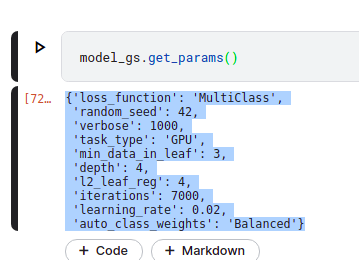

## Финальное обучение модели на всех данных для теста 

In [ ]:
params = {'loss_function': 'MultiClass',
          'random_seed': 42,
          'verbose': 1000,
          'learning_rate': 0.02,
#           'depth': 6,
          'thread_count': -1,
          'l2_leaf_reg': 3,
          'n_estimators': 6600,
          'task_type': 'GPU'}


In [ ]:
model = CatBoostClassifier(**params)
    
model.fit(Train_Valid)


Test = Pool(data = X_sub,
            cat_features = cat_features,
            text_features = text_features)


preds_proba_gs = model.predict_proba(Test)
predictions_gs = pd.DataFrame(preds_proba_gs)

sub_gs = pd.read_csv('../input/two-sigma-connect-rental-listing-inquiries/sample_submission.csv.zip')

sub_gs['high'] = predictions_gs[0]
sub_gs['medium'] = predictions_gs[1]
sub_gs['low'] = predictions_gs[2]


sub_gs.head()
sub_gs.to_csv('submission_final.csv', index = False)